In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
from typing import Tuple, Optional
df_predictions = pd.read_csv("data/cleaned/predictions.csv")
df_inventory = pd.read_excel("data/raw/catusita/inventory.xlsx")
df_rfm = pd.read_csv("data/process/df_rfm.csv")
df_tc = pd.read_excel("data/raw/catusita/saldo de todo 04.11.2024.2.xls", skiprows=2)
df_products = pd.read_csv("data/process/catusita_consolidated.csv")
try:
    df_backorder = pd.read_excel("/data/raw/catusita/backorder12_12.xlsx")
except FileNotFoundError:
    df_backorder = pd.DataFrame()

### to_datime
df_tc['Ult. Fecha'] = pd.to_datetime(df_tc['Ult. Fecha'], errors='coerce')
df_products['fecha'] = pd.to_datetime(df_products['fecha'])
df_predictions['date'] = pd.to_datetime(df_predictions['date'])
df_inventory['FECHA AL'] = pd.to_datetime(df_inventory['FECHA AL'], format='%Y%m%d')

### processing data for raw tables
## df_tc
df_tc = df_tc[['Código','Mnd','Fob','Ult. Fecha','Ult. Compra']]
df_tc.columns = ['codigo', 'moneda', 'monto', 'ultima_fecha', 'ultima_compra']
df_tc['codigo'] = df_tc['codigo'].astype(str)
df_tc = df_tc.dropna(subset=['ultima_fecha'])
df_tc['codigo'] = df_tc['codigo'].str.lower()
df_tc = df_tc[df_tc['ultima_fecha'].notna()]

## df_product
df_products['fecha_mensual'] = df_products['fecha'].dt.to_period('M').dt.to_timestamp()       
# crear variable precio
df_products['precio'] = df_products['venta_pen'] / df_products['cantidad']
# crear variable margen
df_products['margen'] = df_products['venta_pen'] / df_products['costo'] - 1
df_margin_result = df_products.groupby('articulo').agg(
    total_venta_pen=('venta_pen', 'sum'),
    mean_margen=('margen', 'mean')
).reset_index().sort_values(by='total_venta_pen', ascending=False)
# agregar por fecha_mensual, articulo, fuente_suministro 
df_products = df_products.groupby(['fecha_mensual', 'articulo', 'fuente_suministro']).agg({
    'codigo': 'first', 
    'cantidad': 'sum',
    'transacciones': 'sum',
    'venta_pen': 'sum', 
    'costo': 'mean',
    'precio': 'mean',
    'lt': 'first'
}).reset_index().rename(columns={'venta_pen': 'total_venta_pen','margen': 'mean_margen'})

## df_predictions
df_predictions = df_predictions.rename(columns={'sku': 'articulo'})

## df_inventory
df_inventory.columns = ['cia', 'date', 'codigo', 'descripcion', 'um', 'stock']
df_inventory.loc[:, 'codigo'] = df_inventory['codigo'].str.lower()
df_inventory = df_inventory.groupby(['date','codigo','descripcion','um']).agg(
    {
        'stock':'sum'
    }
).reset_index()

# Get currency data 
start = df_tc['ultima_fecha'].min().date()
end = df_tc['ultima_fecha'].max().date()
currency_pairs = ['PENUSD=X', 'EURUSD=X', 'JPYUSD=X', 'GBPUSD=X']
data = yf.download(currency_pairs, start=start, end=end)
df_closing_prices = data['Close']
df_closing_prices.columns = [col.split('.')[0] for col in df_closing_prices.columns]

# process currency data
df_long_format = df_closing_prices.reset_index().melt(id_vars='Date', var_name='Currency Pair', value_name='Closing Price')
df_long_format['Currency Pair'] = df_long_format['Currency Pair'].str.replace('=X', '', regex=False)
df_long_format = df_long_format.dropna(subset=['Closing Price'])

full_date_range = pd.date_range(start=df_long_format['Date'].min(), end=df_long_format['Date'].max(), freq='D')
currency_pairs = df_long_format['Currency Pair'].unique()
complete_index = pd.MultiIndex.from_product([full_date_range, currency_pairs], names=['Date', 'Currency Pair'])
df_temp = pd.DataFrame(index=complete_index).reset_index()

df_long_format = df_temp.merge(df_long_format, on=['Date', 'Currency Pair'], how='left')
df_long_format['Closing Price'] = df_long_format.groupby('Currency Pair')['Closing Price'].ffill()
df_long_format = df_long_format.rename(columns={'Closing Price': 'tc'})

# merge exchange rates
df_tc_merged = pd.merge(df_tc, df_long_format, left_on='ultima_fecha', right_on='Date', how='left')
df_tc_merged['monto'] = pd.to_numeric(df_tc_merged['monto'], errors='coerce')
df_tc_merged['tc'] = pd.to_numeric(df_tc_merged['tc'], errors='coerce')

def convert_to_usd(row):
    if pd.isna(row['Currency Pair']) or row['moneda'] == 'USD':
        return row['monto']
    currency_pair_map = {'SOL': 'PENUSD', 'EUR': 'EURUSD', 'JPY': 'JPYUSD', 'GBP': 'GBPUSD'}
    if row['moneda'] in currency_pair_map and row['Currency Pair'] == currency_pair_map[row['moneda']]:
        return row['monto'] / row['tc'] if row['moneda'] == 'SOL' else row['monto'] * row['tc']
    return 0

df_tc_merged['monto_usd'] = df_tc_merged.apply(convert_to_usd, axis=1)
df_tc_merged = df_tc_merged[df_tc_merged['monto_usd'] != 0]
df_tc_final = df_tc_merged[['codigo', 'ultima_fecha', 'monto_usd', 'ultima_compra']]
df_tc_final = df_tc_final[df_tc_final['monto_usd'].notna()]

# cleaning df_inventory with df_products
max_date = df_inventory['date'].max()
df_inventory = df_inventory[
    (df_inventory['date'] != 'Periodo') & 
    (df_inventory['date'].notna())&
    (df_inventory['date']==max_date)
]
df_inventory_final=pd.concat(
    [
        pd.DataFrame(df_inventory['codigo'].unique(), columns=['codigo']),
        pd.DataFrame(df_products['articulo'].unique(), columns=['codigo'])
    ], 
    ignore_index=True
).drop_duplicates()
df_inventory = df_inventory_final.merge(
    df_inventory[['date','codigo','stock','descripcion']].drop_duplicates(),
    how='left',
    on='codigo'
)
df_inventory['stock']=df_inventory['stock'].fillna(0)
df_inventory['date'] = df_inventory['date'].fillna(max_date)
# merging df_predictions, df_products and df_invetory
df_merged = df_predictions.copy()
df_merged = df_merged.merge(
    df_products[['articulo','fuente_suministro']].drop_duplicates(), 
    how='left', 
    on = 'articulo'
)
df_merged = df_merged.merge(
    df_inventory[['codigo','stock','descripcion']], 
    how='left', 
    left_on=['articulo'],
    right_on=['codigo']
)

# merging df_tc_final, df_backorder, rfm and df_margin_result
df_merged = df_merged.merge(
    df_margin_result[['articulo', 'mean_margen']], 
    how='left', 
    on='articulo'
)
df_merged = df_merged.merge(
    df_tc_final, 
    how='left', 
    left_on='articulo', 
    right_on='codigo'
)
if not df_backorder.empty:
    df_merged = df_merged.merge(
        df_backorder, 
        how='left', 
        on='articulo'
    )
else:
    df_merged['backorder'] = np.nan

df_merged['backorder'] = df_merged['backorder'].fillna(0)

df_merged = df_merged.merge(
    df_rfm, 
    left_on='articulo',
    right_on='sku',
    how='left'
)
df_merged['rfm'] = df_merged['rfm'].fillna(0).astype(int)
df_merged = df_merged.drop_duplicates()

# adding demanda_mensual and meses_proteccion    
df_merged['demanda_mensual'] = df_merged['caa'] / df_merged['lt']
df_merged['meses_proteccion'] = df_merged['corr_sd'] / df_merged['demanda_mensual']

# adding compra_sugerida
df_merged['sobrante'] = np.maximum(df_merged['stock'] + df_merged['backorder'] - df_merged['caa_lt'], 0)
df_merged['compra_sugerida'] = np.maximum(df_merged['caa'] - df_merged['sobrante'], 0)
df_merged['compra_sugerida'] = np.ceil(df_merged['compra_sugerida']).astype('Int64')
df_merged['compra_sugerida'] = df_merged['compra_sugerida'].astype("Float64")
df_merged['meses_proteccion'] = df_merged['meses_proteccion'].astype("Float64")
# mask = df_merged['demanda_mensual'] != 0
# df_merged.loc[mask, 'meses_proteccion'] = (
#     df_merged.loc[mask, 'meses_proteccion'] * 
#     (df_merged.loc[mask, 'compra_sugerida'].fillna(0) / df_merged.loc[mask, 'demanda_mensual'])
# ).astype("Float64")

# adding costo_compra and compras_recomendadas
df_merged = df_merged.rename(columns={'caa': 'compras_recomendadas'})
# df_merged = df_merged.rename(columns={'compra_sugerida': 'compras_recomendadas'})
df_merged.loc[df_merged['demanda_mensual'] < 0, 'demanda_mensual'] = 0
df_merged.loc[df_merged['compras_recomendadas'] < 0, 'compras_recomendadas'] = 0
df_merged['compras_recomendadas'] = df_merged['compras_recomendadas'].apply(
    lambda x: math.ceil(x / 50) * 50 if pd.notna(x) else pd.NA
)
df_merged['costo_compra'] = df_merged['monto_usd'] * df_merged['compras_recomendadas']

# Calcular riesgo
df_merged['holgura'] = (df_merged['stock'] / df_merged['demanda_mensual']).fillna(0)
df_merged['consumiendo_proteccion'] = (df_merged['holgura'] < df_merged['meses_proteccion']).astype('Int64')
df_merged['quebro'] = (df_merged['holgura'] <= 0).astype('Int64')
df_merged['va_a_quebrar'] = ((df_merged['stock'] + df_merged['backorder']) < df_merged['demanda_mensual']).astype('Int64')
df_merged['verde'] = (
    (df_merged['quebro'] == 0) & 
    (df_merged['consumiendo_proteccion'] == 0) & 
    (df_merged['va_a_quebrar'] == 0)
).astype('Int64')
df_merged['amarillo'] = (
    (df_merged['consumiendo_proteccion'] == 1) & 
    (df_merged['quebro'] == 0)
).astype('Int64')
df_merged['rojo'] = (
    (df_merged['quebro'] == 1) |
    (df_merged['va_a_quebrar'] == 1) 
).astype('Int64')
df_merged['riesgo'] = df_merged.apply(
    lambda row: 'rojo' if pd.notna(row.get('rojo')) and row['rojo'] == 1 else 
                'amarillo' if pd.notna(row.get('amarillo')) and row['amarillo'] == 1 else 
                ('verde' if pd.notna(row.get('rojo')) or pd.notna(row.get('amarillo')) else np.nan),
    axis=1
)

# modificar period2 (caa_lt)
df_merged['caa_lt'] += df_merged['corr_sd'] * df_merged['rfm'].map({3: 0.4, 2: 0.3, 1: 0.2, 0: 0.1}).fillna(0)

# filtrar solo las importantes para la tabla por fuente de suministro
df_merged['demanda_mensual_usd'] = df_merged['demanda_mensual'] * df_merged['monto_usd']
df_temp = df_merged.copy()
df_temp = df_temp[(df_temp['rfm'] == 3) & (df_temp['riesgo'] == 'rojo')]
df_temp = df_temp.groupby('fuente_suministro').agg(
    recomendacion=('costo_compra', 'sum'),
    demanda_mensual_usd=('demanda_mensual_usd', 'sum')
).reset_index()
df_temp_2 = df_merged.groupby('fuente_suministro').agg(
    lead_time=('lt', 'first'),
    riesgo=('riesgo', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()
df_dashboard_by_fuente = df_temp_2.merge(df_temp, how='left', on='fuente_suministro')
df_dashboard_by_fuente['recomendacion'] = pd.to_numeric(df_dashboard_by_fuente['recomendacion'], errors='coerce').fillna(0).astype(int)
df_dashboard_by_fuente['demanda_mensual_usd'] = pd.to_numeric(df_dashboard_by_fuente['demanda_mensual_usd'], errors='coerce').fillna(0).astype(int)


[*********************100%***********************]  4 of 4 completed


In [ ]:
######## analisis producto mas vendido

       articulo         fuente_suministro                          descripcion
1916  paw68a500  prextoline - lubricantes  ACEITE AW68 PREXTOFLUID ISO68 AMBAR


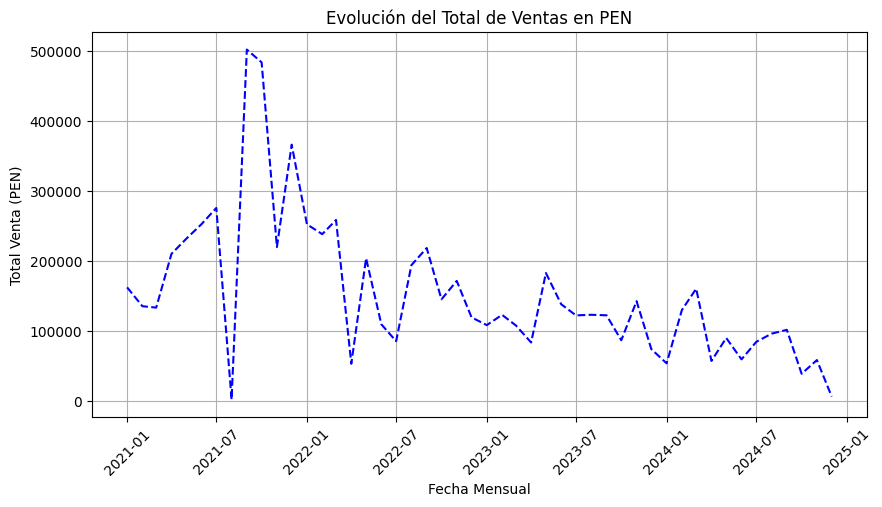

In [2]:
import matplotlib.pyplot as plt
articulo_mas_venta = df_margin_result.iloc[0]['articulo']
df_ppt = df_products.merge(df_inventory[['codigo','descripcion']], how='left',left_on='articulo',right_on='codigo')
df_ppt = df_ppt[df_ppt['articulo']==articulo_mas_venta]
print(df_ppt[df_ppt['articulo']==articulo_mas_venta][['articulo','fuente_suministro','descripcion']].head(1))

# Graficar la evolución con una línea conectando los puntos
plt.figure(figsize=(10,5))
plt.plot(df_ppt["fecha_mensual"], df_ppt["total_venta_pen"], linestyle="--", color="b")

# Etiquetas y título
plt.xlabel("Fecha Mensual")
plt.ylabel("Total Venta (PEN)")
plt.title("Evolución del Total de Ventas en PEN")
plt.grid(True)

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.show()

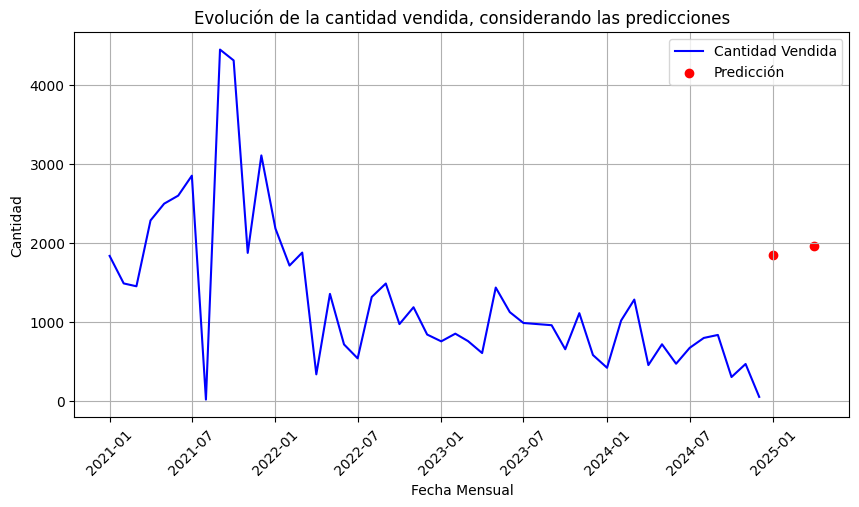

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar el DataFrame con el artículo más vendido
df_ppt2 = df_products[df_products['articulo'] == articulo_mas_venta][['fecha_mensual', 'articulo', 'cantidad']]

# Convertir la fila de df_ppt3 en columnas separadas
df_ppt3_original = df_merged[df_merged['articulo'] == articulo_mas_venta][['compras_recomendadas', 'caa_lt']]

# Transformar en formato adecuado (2 filas en lugar de 1)
df_ppt3 = pd.DataFrame({
    "fecha_mensual": pd.to_datetime(["2025-01-01", "2025-04-01"]),
    "cantidad": [df_ppt3_original["compras_recomendadas"].values[0], df_ppt3_original["caa_lt"].values[0]]
})

# Graficar la evolución con una línea conectando los puntos
plt.figure(figsize=(10,5))
plt.plot(df_ppt2["fecha_mensual"], df_ppt2["cantidad"], linestyle="-", color="b", label="Cantidad Vendida")

# Agregar los puntos de predicción con las fechas correctas
plt.scatter(df_ppt3["fecha_mensual"], df_ppt3["cantidad"], color="r", marker="o", label="Predicción")

# Etiquetas y título
plt.xlabel("Fecha Mensual")
plt.ylabel("Cantidad")
plt.title("Evolución de la cantidad vendida, considerando las predicciones")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.show()


In [103]:
df_merged[df_merged['articulo'] == articulo_mas_venta][['articulo',
    'stock', 'lt', 'backorder', 'compras_recomendadas', 'caa_lt', 
    'sobrante', 'compra_sugerida', 'meses_proteccion'
]].rename(columns={'compras_recomendadas': 'caa_lt','caa_lt':'caa_2lt','compra_sugerida':'compra_sugerida'}).to_csv('prediccion_articulo_mas_vendido.csv')


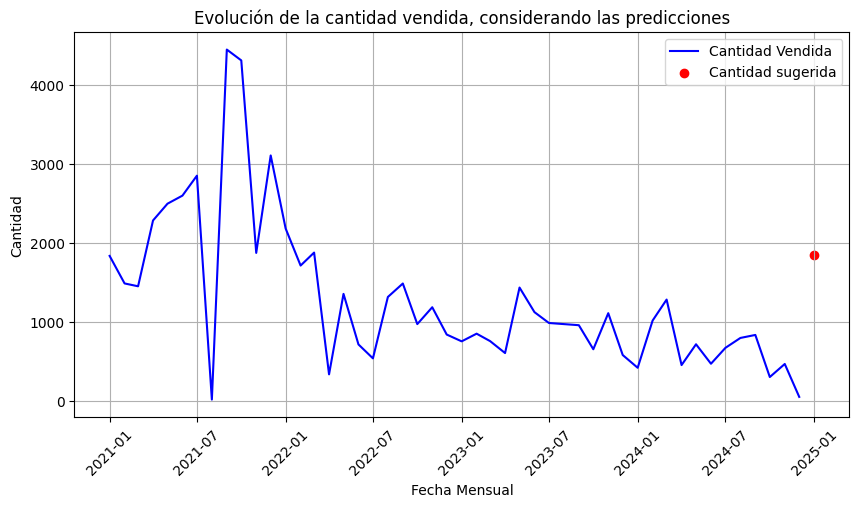

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar el DataFrame con el artículo más vendido
df_ppt2 = df_products[df_products['articulo'] == articulo_mas_venta][['fecha_mensual', 'articulo', 'cantidad']]

# Convertir la fila de df_ppt3 en columnas separadas
df_ppt3_original = df_merged[df_merged['articulo'] == articulo_mas_venta][['compra_sugerida', 'caa_lt']]

# Transformar en formato adecuado (2 filas en lugar de 1)
df_ppt3 = pd.DataFrame({
    "fecha_mensual": pd.to_datetime(["2025-01-01"]),
    "cantidad": [df_ppt3_original["compra_sugerida"].values[0]]
})

# Graficar la evolución con una línea conectando los puntos
plt.figure(figsize=(10,5))
plt.plot(df_ppt2["fecha_mensual"], df_ppt2["cantidad"], linestyle="-", color="b", label="Cantidad Vendida")

# Agregar los puntos de predicción con las fechas correctas
plt.scatter(df_ppt3["fecha_mensual"], df_ppt3["cantidad"], color="r", marker="o", label="Cantidad sugerida")

# Etiquetas y título
plt.xlabel("Fecha Mensual")
plt.ylabel("Cantidad")
plt.title("Evolución de la cantidad vendida, considerando las predicciones")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.show()


In [8]:
df_temp = df_products[df_products['articulo'] == articulo_mas_venta].sort_values('fecha_mensual',ascending=False).head(6)
df_temp['cantidad'].mean()

np.float64(523.1666666666666)

In [ ]:
##### finaliza analisis producto mas vendido
######## empieza analisis de predicciones

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class Predictor:
    def __init__(self):
        self.scaler = StandardScaler()

    def load_and_preprocess_data(self, data_path):
        df = pd.read_csv(data_path)
        df['fecha'] = pd.to_datetime(df['fecha'])
        df = df.sort_values(by=['articulo', 'fecha'])
        return df

    def load_covariates_data(self, cov_path):
        return pd.read_csv(cov_path)

    def create_monthly_sales_data(self, df):
        df.loc[:, 'year'] = df['fecha'].dt.year
        df.loc[:, 'month'] = df['fecha'].dt.month

        monthly_data = df.groupby(['articulo', 'year', 'month']).agg({
            'cantidad': 'sum',
            'transacciones': 'sum',
            'venta_pen': 'sum',
            'fuente_suministro': 'first',
            'lt': 'first'
        }).reset_index()

        monthly_data['fecha'] = pd.to_datetime(monthly_data.apply(
            lambda row: pd.Timestamp(year=int(row['year']), month=int(row['month']), day=1), axis=1))
        monthly_data['lt'] = monthly_data['lt'].fillna(0)
        return monthly_data.sort_values(by=['articulo', 'fecha'])

    def select_features_with_lasso(self, X, y, feature_columns, alpha=0.01):
        """
        Perform feature selection using LASSO regression.
        Returns selected feature names based on non-zero coefficients.
        """
        X_scaled = self.scaler.fit_transform(X)
        
        lasso = Lasso(alpha=alpha, random_state=42)
        lasso.fit(X_scaled, y)
        
        selected_features = [feature for feature, coef in zip(feature_columns, lasso.coef_) 
                        if abs(coef) > 0]
                
        return selected_features

    def prepare_features_for_ml(self, all_monthly_data, df_cov, df_correlaciones_sig, sku):
        sku_correlations = df_correlaciones_sig[df_correlaciones_sig['sku'] == sku]
        
        if len(sku_correlations) == 0:
            return all_monthly_data[all_monthly_data['articulo'] == sku].copy(), []
            
        data = all_monthly_data[all_monthly_data['articulo'] == sku].merge(
            df_cov, on=['year', 'month'], how='left'
        )
        
        feature_columns = []
        for _, row in sku_correlations.iterrows():
            col_name = row['tipo']
            lag = row['lag']
            if lag > 0:
                data[f'{col_name}_lag_{lag}'] = data[col_name].shift(lag)
                feature_columns.append(f'{col_name}_lag_{lag}')
            else:
                feature_columns.append(col_name)
        
        data = data.dropna()
        
        if len(data) > 0 and len(feature_columns) > 0:
            X = data[feature_columns]
            y = data['cantidad']
            selected_features = self.select_features_with_lasso(X, y, feature_columns)
            return data, selected_features
        
        return data, []

    def weighted_mape(self, y_true, y_pred):
        errors = []
        for true, pred in zip(y_true, y_pred):
            if pd.isna(true) or pd.isna(pred) or true == 0:
                continue
            error = abs((true - pred) / true)
            if pred < true:  # underprediction
                error *= 2
            errors.append(error)
        return np.mean(errors) * 100 if errors else float('inf')

    def ES_forecast(self, series, alpha):
        series = np.array(series)
        result = [series[0]]
        for n in range(1, len(series)):
            result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        return result[-1]

    def ES_opt_alpha(self, series):
        series = np.array(series)
        alpha_list = np.linspace(0.1, 0.9, 100)
        errors = []
        
        for alpha in alpha_list:
            error = []
            for i in range(1, len(series)-1):
                forecast = self.ES_forecast(series[:i], alpha)
                error.append(abs(forecast - series[i+1]))
            errors.append(np.mean(error))
        
        return alpha_list[np.argmin(errors)]

    def evaluate_models(self, data, feature_columns, target_col='cantidad', 
                    lookback_periods=[6, 12, None], val_year=None):
        best_score = float('inf')
        best_config = None
        best_model = None
        
        if len(data) < 4:
            return None, None, float('inf')
            
        val_data = data[data['year'] == val_year] if val_year else data
        val_size = 6
        
        for lookback in lookback_periods:
            train_data = (val_data.iloc[-(lookback+val_size):-val_size] 
                        if lookback else val_data.iloc[:-val_size])
            test_data = val_data.iloc[-val_size:]
            
            # if len(train_data) < 2:
            #     continue
                
            y_train = train_data['cantidad']
            y_test = test_data['cantidad']
            
            models = {
                'mean': y_train.mean(),
                'median': y_train.median(),
                'es': (self.ES_forecast, self.ES_opt_alpha(y_train))
            }
            
            if len(feature_columns) > 0:
                models.update({
                    'xgboost': xgb.XGBRegressor(random_state=42),
                    'linear': LinearRegression()
                })
                X_train = train_data[feature_columns]
                X_test = test_data[feature_columns]
            
            for model_name, model in models.items():
                try:
                    if model_name in ['xgboost', 'linear']:
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                    elif model_name == 'es':
                        forecast_func, alpha = model
                        y_pred = []
                        current_data = y_train.values
                        for _ in range(len(y_test)):
                            pred = forecast_func(current_data, alpha)
                            y_pred.append(pred)
                            current_data = np.append(current_data, pred)
                    else:  # mean or median
                        y_pred = [model] * len(y_test)
                    
                    score = self.weighted_mape(y_test, y_pred)
                    
                    if score < best_score:
                        best_score = score
                        best_config = (model_name, lookback)
                        best_model = model
                        
                except Exception as e:
                    continue
        
        return best_config, best_model, best_score

    def predict_future_months(self, data, feature_columns, best_model, 
                            best_model_name, lookback, num_months):
        predictions = []
        current_data = data.copy()
        
        for _ in range(num_months):
            if best_model_name in ['xgboost', 'linear']:
                pred = best_model.predict(current_data[feature_columns].iloc[-1:])[0]
            elif best_model_name in ['mean', 'median']:
                pred = best_model
            else:  # ES
                forecast_func, alpha = best_model
                lookback_data = (current_data.iloc[-lookback:] if lookback 
                               else current_data)
                pred = forecast_func(lookback_data['cantidad'].dropna(), alpha)
            
            predictions.append(pred)
            
            new_row = current_data.iloc[-1:].copy()
            new_row['cantidad'] = pred
            new_row['fecha'] += pd.DateOffset(months=1)
            new_row['month'] = new_row['fecha'].dt.month
            new_row['year'] = new_row['fecha'].dt.year
            
            current_data = pd.concat([current_data, new_row])
            
            if feature_columns:
                for lag in range(1, 4):
                    current_data[f'cantidad_lag_{lag}'] = current_data['cantidad'].shift(lag)
            
        return predictions

    def make_final_predictions(self, all_monthly_data, df_cov, df_correlaciones_sig):
        results = []
        no_sku_process_list = []
        count = 0
        for sku in all_monthly_data['articulo'].unique():
            print(f"Processing SKU: {sku}")
            try:
                sku_data = all_monthly_data[all_monthly_data['articulo'] == sku].copy()
                last_date = sku_data['fecha'].max()
                last_date = (last_date + pd.offsets.MonthBegin(1)).normalize()
                lt = int(sku_data['lt'].iloc[-1])
                last_year = sku_data['year'].max()

                # if len(sku_data) < 7:
                #     continue

                data, feature_columns = self.prepare_features_for_ml(
                    all_monthly_data, df_cov, df_correlaciones_sig, sku
                )

                best_config, best_model, score = self.evaluate_models(
                    data,
                    feature_columns,
                    lookback_periods=[6, 12, None],
                    val_year=last_year - 1
                )

                # if best_config is None:
                #     continue

                if best_config is None or best_model is None:
                    results.append({
                        'sku': sku,
                        'lt': lt,
                        'date': last_date,
                        'model': np.nan,
                        'real': 0,
                        'catusita': np.nan,
                        'lookback_period': np.nan,
                        'features_used': 'none',
                        'caa': np.nan,
                        'caa_lt': np.nan,
                        'corr_sd': np.nan,
                        'loss': np.nan
                    })
                    # print(f"SKU {sku} no pudo ser evaluado. Datos insuficientes o problema en los datos.")
                    no_sku_process_list.append({'sku':sku})
                    # pd.DataFrame(no_sku_process_list,columns=['sku']).to_csv('data/cleaned/no_sku_process_list.csv')
                    count = count + 1
                    continue

                best_model_name, lookback = best_config

                # Calculate test score
                test_data = data[data['year'] == last_year]
                if feature_columns:
                    test_X = test_data[feature_columns]
                    if best_model_name in ['xgboost', 'linear']:
                        test_pred = best_model.predict(test_X)
                else:
                    if best_model_name in ['mean', 'median']:
                        test_pred = [best_model] * len(test_data)
                    else:  # ES
                        forecast_func, alpha = best_model
                        test_pred = []
                        current_data = data[data['year'] < last_year]['cantidad'].values
                        for _ in range(len(test_data)):
                            pred = forecast_func(current_data, alpha)
                            test_pred.append(pred)
                            current_data = np.append(current_data, pred)

                test_score = self.weighted_mape(test_data['cantidad'], test_pred)

                # Generate future predictions
                future_predictions = self.predict_future_months(
                    data,
                    feature_columns,
                    best_model,
                    best_model_name,
                    lookback,
                    2 * lt
                )

                # Calculate pred_std from the historical data used for prediction
                if lookback:
                    historical_data = data['cantidad'].iloc[-lookback:]
                else:
                    historical_data = data['cantidad']
                pred_std = np.std(historical_data)

                period1 = sum(future_predictions[:lt])
                period2 = sum(future_predictions[lt:2*lt])

                # period2 += 0.4 * pred_std

                last_six_months_mean = sku_data.tail(6)['cantidad'].mean()

                results.append({
                    'sku': sku,
                    'lt': lt,
                    'date': last_date,
                    'model': best_model_name,
                    'real': 0,
                    'catusita': last_six_months_mean,
                    'lookback_period': lookback if lookback else 'all',
                    'features_used': ','.join(feature_columns) if feature_columns else 'none',
                    'caa': period1,
                    'caa_lt': period2,
                    'corr_sd': pred_std,
                    'loss': test_score
                })

            except Exception as e:
                # print(f"Error processing SKU {sku}: {str(e)}")
                continue
        print(f"El numero de SKU sin procesar: {count}")
        return pd.DataFrame(results)

    def process_predictions(self):
        from utils.process_data.config import DATA_PATHS
        
        data_path = DATA_PATHS['process'] / 'catusita_consolidated.csv'
        cov_path = DATA_PATHS['process'] / 'df_covariables.csv'
        
        all_monthly_data = self.create_monthly_sales_data(
            self.load_and_preprocess_data(data_path)
        )
        df_cov = self.load_covariates_data(cov_path)
        df_correlaciones_sig = pd.read_csv(DATA_PATHS['process'] / 'df_correlaciones_sig.csv')
        
        results_df = self.make_final_predictions(
            all_monthly_data, 
            df_cov, 
            df_correlaciones_sig
        )

        # results_df = results_df[results_df['date'] == results_df['date'].max()]

        if not results_df.empty:
            return results_df.sort_values('loss')
        return None


In [2]:
from utils.process_data.config import DATA_PATHS
# from utils.predictions.predictor import Predictor
predictor = Predictor()
# predictions_df = predictor.process_predictions()

data_path = DATA_PATHS['process'] / 'catusita_consolidated.csv'
cov_path = DATA_PATHS['process'] / 'df_covariables.csv'

all_monthly_data = predictor.create_monthly_sales_data(
    predictor.load_and_preprocess_data(data_path)
)
df_cov = predictor.load_covariates_data(cov_path)
df_correlaciones_sig = pd.read_csv(DATA_PATHS['process'] / 'df_correlaciones_sig.csv')

# results_df = predictor.make_final_predictions(
#     all_monthly_data, 
#     df_cov, 
#     df_correlaciones_sig
# )

In [3]:
sku = 'paw68a500'

In [4]:
all_monthly_data[all_monthly_data['articulo']=='paw68a500'].sort_values('fecha', ascending=False).head(12)

articulo  year  month  cantidad  transacciones  venta_pen  \
93448  paw68a500  2024     12      54.0              2    6528.47   
93447  paw68a500  2024     11     470.0             27   58562.58   
93446  paw68a500  2024     10     305.0             26   39001.46   
93445  paw68a500  2024      9     837.0             36  101765.23   
93444  paw68a500  2024      8     799.0             39   96249.06   
93443  paw68a500  2024      7     674.0             35   84600.35   
93442  paw68a500  2024      6     473.0             25   59556.25   
93441  paw68a500  2024      5     719.0             30   90082.59   
93440  paw68a500  2024      4     456.0             28   57327.50   
93439  paw68a500  2024      3    1284.0             51  160484.96   
93438  paw68a500  2024      2    1019.0             35  130062.67   
93437  paw68a500  2024      1     422.0             24   53866.50   

              fuente_suministro   lt      fecha  
93448  prextoline - lubricantes  2.0 2024-12-01  
93447  prextoline - lubricantes  2.0 2024-11-01  
93446  prextoline - lubricantes  2.0 2024-10-01  
93445  prextoline - lubricantes  2.0 2024-09-01  
93444  prextoline - lubricantes  2.0 2024-08-01  
93443  prextoline - lubricantes  2.0 2024-07-01  
93442  prextoline - lubricantes  2.0 2024-06-01  
93441  prextoline - lubricantes  2.0 2024-05-01  
93440  prextoline - lubricantes  2.0 2024-04-01  
93439  prextoline - lubricantes  2.0 2024-03-01  
93438  prextoline - lubricantes  2.0 2024-02-01  
93437  prextoline - lubricantes  2.0 2024-01-01

In [5]:
df_cov.head()

year  month  Hibridos y Electricos  Livianos  Menores  Pesados  \
0  2020      1                   51.0   14420.0  25197.0   1381.0   
1  2020      2                   53.0   12753.0  22494.0   1137.0   
2  2020      3                   42.0    7084.0  12592.0    580.0   
3  2020      4                   42.0    7084.0  12592.0    580.0   
4  2020      5                   42.0     348.0    185.0     27.0   

   Remolques y SemiR    Neumáticos   Lubricantes  Partes de Motor  ...  \
0              410.0  4.222718e+07  2.762023e+07     2.656240e+07  ...   
1              334.0  2.819364e+07  1.924647e+07     2.266911e+07  ...   
2              183.0  2.003285e+07  2.594233e+07     1.490268e+07  ...   
3              183.0  3.007109e+07  2.570013e+07     1.250405e+07  ...   
4                7.0  2.850129e+07  1.241780e+07     1.236305e+07  ...   

   Sistema de frenos     Baterías  Sistema de suspensión   Accesorios  \
0        4106407.664  3827787.802            2862318.494  2486253.950   
1        3332410.839  2906918.541            3075611.878  2302485.475   
2        2327674.710  1932872.809            2024623.605  1919918.731   
3        2458361.309  1391027.834            1896856.959  1117306.921   
4        1914440.701  1587255.421            1132746.440  1670601.475   

   Ruedas y sus partes  Productos de caucho  Sistema de dirección  \
0          1526067.344          2104315.510           1828623.462   
1          1898314.536          1730286.225           1530739.708   
2          1037609.573          1260022.243            693044.502   
3           883819.533          1015749.498            622813.906   
4          1511083.002          1219568.677            622659.173   

   Sistema de enfriamiento  Ejes y diferencial  Sistema de escape  
0              1200065.896         1454949.952         514298.718  
1               978654.869         1065694.594         692901.929  
2               381527.233          859822.498         264183.002  
3               518195.523          634857.940         235871.411  
4               549842.197          426656.089         134154.035  

[5 rows x 25 columns]

In [6]:
df_correlaciones_sig[df_correlaciones_sig['sku']=='paw68a500'].head()

lag                   tipo  corr        sku
218920    0  Hibridos y Electricos   0.0  paw68a500
218921    0               Livianos   0.0  paw68a500
218922    0                Menores   0.0  paw68a500
218923    0                Pesados   0.0  paw68a500
218924    0      Remolques y SemiR   0.0  paw68a500

In [7]:
results = []
try:
    sku_data = all_monthly_data[all_monthly_data['articulo'] == sku].copy()
    last_date = sku_data['fecha'].max()
    last_date = (last_date + pd.offsets.MonthBegin(1)).normalize()
    lt = int(sku_data['lt'].iloc[-1])
    last_year = sku_data['year'].max()

    # if len(sku_data) < 7:
    #     continue

    data, feature_columns = predictor.prepare_features_for_ml(
        all_monthly_data, df_cov, df_correlaciones_sig, sku
    )

    best_config, best_model, score = predictor.evaluate_models(
        data,
        feature_columns,
        lookback_periods=[6, 12, None],
        val_year=last_year - 1
    )

    # if best_config is None:
    #     continue

    if best_config is None or best_model is None:
        results.append({
            'sku': sku,
            'lt': lt,
            'date': last_date,
            'model': np.nan,
            'real': 0,
            'catusita': np.nan,
            'lookback_period': np.nan,
            'features_used': 'none',
            'caa': np.nan,
            'caa_lt': np.nan,
            'corr_sd': np.nan,
            'loss': np.nan
        })
        print(f"SKU {sku} no pudo ser evaluado. Datos insuficientes o problema en los datos.")
        
    best_model_name, lookback = best_config

    # Calculate test score
    test_data = data[data['year'] == last_year]
    if feature_columns:
        test_X = test_data[feature_columns]
        if best_model_name in ['xgboost', 'linear']:
            test_pred = best_model.predict(test_X)
    else:
        if best_model_name in ['mean', 'median']:
            test_pred = [best_model] * len(test_data)
        else:  # ES
            forecast_func, alpha = best_model
            test_pred = []
            current_data = data[data['year'] < last_year]['cantidad'].values
            for _ in range(len(test_data)):
                pred = forecast_func(current_data, alpha)
                test_pred.append(pred)
                current_data = np.append(current_data, pred)

    test_score = predictor.weighted_mape(test_data['cantidad'], test_pred)

    # Generate future predictions
    future_predictions = predictor.predict_future_months(
        data,
        feature_columns,
        best_model,
        best_model_name,
        lookback,
        2 * lt
    )

    # Calculate pred_std from the historical data used for prediction
    if lookback:
        historical_data = data['cantidad'].iloc[-lookback:]
    else:
        historical_data = data['cantidad']
    pred_std = np.std(historical_data)

    period1 = sum(future_predictions[:lt])
    period2 = sum(future_predictions[lt:2*lt])

    # period2 += 0.4 * pred_std

    last_six_months_mean = sku_data.tail(6)['cantidad'].mean()

    results.append({
        'sku': sku,
        'lt': lt,
        'date': last_date,
        'model': best_model_name,
        'real': 0,
        'catusita': last_six_months_mean,
        'lookback_period': lookback if lookback else 'all',
        'features_used': ','.join(feature_columns) if feature_columns else 'none',
        'caa': period1,
        'caa_lt': period2,
        'corr_sd': pred_std,
        'loss': test_score
    })

except Exception as e:
    print(f"Error processing SKU {sku}: {str(e)}")


Error processing SKU paw68a500: name 'test_pred' is not defined


In [ ]:
results = []
try:
    sku_data = all_monthly_data[all_monthly_data['articulo'] == sku].copy()
    last_date = sku_data['fecha'].max()
    last_date = (last_date + pd.offsets.MonthBegin(1)).normalize()
    lt = int(sku_data['lt'].iloc[-1])
    last_year = sku_data['year'].max()

    lookback_periods=[6, 12, None]
    val_year=last_year - 1

    data, feature_columns = predictor.prepare_features_for_ml(
        all_monthly_data, df_cov, df_correlaciones_sig, sku
    )

    # best_config, best_model, score = predictor.evaluate_models(
    #     data,
    #     feature_columns,
    #     lookback_periods=[6, 12, None],
    #     val_year=last_year - 1
    # )

    ## empieza evaluate_models()

    best_score = float('inf')
    best_config = None
    best_model = None
    
    # if len(data) < 4:
    #     return None, None, float('inf')
        
    val_data = data[data['year'] == val_year] if val_year else data
    val_size = 6
    
    for lookback in lookback_periods:
        train_data = (val_data.iloc[-(lookback+val_size):-val_size] 
                    if lookback else val_data.iloc[:-val_size])
        test_data = val_data.iloc[-val_size:]
        print(f"\n ========== Estamos en el lookback {lookback} con un val_size {val_size} de tal forma que ==========\n")
        print(f el train_data tiene fechas unicas {train_data['fecha'].unique()} y el test_data {test_data['fecha'].unique()} ==========\n")

        
        # if len(train_data) < 2:
        #     continue
            
        y_train = train_data['cantidad']
        y_test = test_data['cantidad']
        
        models = {
            'mean': y_train.mean(),
            'median': y_train.median(),
            'es': (predictor.ES_forecast, predictor.ES_opt_alpha(y_train))
        }
        print(f"por lo tanto el mean y median del train_data['cantidad'] son {models['mean']} y {models['median']}\n")
        
        if len(feature_columns) > 0:
            models.update({
                'xgboost': xgb.XGBRegressor(random_state=42),
                'linear': LinearRegression()
            })
            X_train = train_data[feature_columns]
            X_test = test_data[feature_columns]
        
        for model_name, model in models.items():
            try:
                if model_name in ['xgboost', 'linear']:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                elif model_name == 'es':
                    forecast_func, alpha = model
                    y_pred = []
                    current_data = y_train.values
                    for _ in range(len(y_test)):
                        pred = forecast_func(current_data, alpha)
                        y_pred.append(pred)
                        current_data = np.append(current_data, pred)
                else:  # mean or median
                    y_pred = [model] * len(y_test)
                
                score = predictor.weighted_mape(y_test, y_pred)
                print(f"el modelo {model_name} tiene score igual a {score}")
                
                if score < best_score:
                    best_score = score
                    best_config = (model_name, lookback)
                    best_model = model
                    
            except Exception as e:
                continue
except Exception as e:
    print(f"Error processing SKU {sku}: {str(e)}")


 ========== Estamos en el lookback 6 con un val_size 6 de tal forma que ==========

========== el train_data tiene fechas unicas <DatetimeArray>
['2023-01-01 00:00:00', '2023-02-01 00:00:00', '2023-03-01 00:00:00',
 '2023-04-01 00:00:00', '2023-05-01 00:00:00', '2023-06-01 00:00:00']
Length: 6, dtype: datetime64[ns] y el test_data <DatetimeArray>
['2023-07-01 00:00:00', '2023-08-01 00:00:00', '2023-09-01 00:00:00',
 '2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00']
Length: 6, dtype: datetime64[ns] ==========

por lo tanto el mean y median del train_data['cantidad'] son 922.8333333333334 y 806.0

el modelo mean tiene score igual a 27.40503955817309
el modelo median tiene score igual a 36.5957687020634
el modelo es tiene score igual a 33.23716397164735
el modelo xgboost tiene score igual a 81.5614242553711
el modelo linear tiene score igual a 32.20685209706943

 ========== Estamos en el lookback 12 con un val_size 6 de tal forma que ==========

========== el train_dat

In [3]:
import requests
import pandas as pd

url = "http://api.catusita.com:8083/api/sales/forDate"

# Parámetros de la consulta
params = {
    "Date1": "20241201",
    "Date2": "20250115"
}

# Encabezados opcionales (puedes agregar más si la API lo requiere)
headers = {
    "Accept": "application/json"  # Asegura que la API devuelva JSON
}

try:
    # Hacer la solicitud GET a la API
    response = requests.get(url, params=params, headers=headers, timeout=10)

    # Verificar si la respuesta fue exitosa
    response.raise_for_status()  # Lanza un error si la respuesta no es 200

    # Intentar convertir la respuesta en JSON
    try:
        data = response.json()
        print(data)  # Imprime los datos obtenidos
    except ValueError:
        print("⚠️ La respuesta no es un JSON válido.")

except requests.exceptions.RequestException as e:
    print(f"❌ Error al conectar con la API: {e}")


# Extraer la lista de datos desde el JSON
data_list = data.get("data", [])  # Asegura que no falle si la clave "data" no existe

# Convertir a DataFrame
df = pd.DataFrame(data_list)

{'data': [{'dateDocument': '2024-12-14T00:00:00', 'document': 'F001-01-0059308', 'codeArticle': 'BDD020', 'nameArticle': 'DISCO DE FRENO DELT VENT BD4113  318.8X28X67.2X108X6', 'codeSupply': 'A569', 'nameSupply': 'ISHIKAWA - DISCOS DE FRENO', 'quantity': 20, 'amountSOL': 2090.18, 'amountUSD': 559.32, 'cost': 1047.88}, {'dateDocument': '2024-12-14T00:00:00', 'document': 'F001-01-0059308', 'codeArticle': 'BDD010S', 'nameArticle': 'DISCO DE FRENO DELT VENT BD7019 294X28X46.3X94X6', 'codeSupply': 'A569', 'nameSupply': 'ISHIKAWA - DISCOS DE FRENO', 'quantity': 6, 'amountSOL': 684.06, 'amountUSD': 183.05, 'cost': 289.759998}, {'dateDocument': '2024-12-14T00:00:00', 'document': 'F001-01-0059308', 'codeArticle': 'BDD012', 'nameArticle': 'DISCO DE FRENO DEL BD4198 296X28X53.1X68X6', 'codeSupply': 'A569', 'nameSupply': 'ISHIKAWA - DISCOS DE FRENO', 'quantity': 4, 'amountSOL': 418.02, 'amountUSD': 111.86, 'cost': 201.55}, {'dateDocument': '2024-12-14T00:00:00', 'document': 'F001-01-0059308', 'cod